<a href="https://colab.research.google.com/github/pati-dev/predict-shopping-intention/blob/master/predict_purchase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boot

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Load Data

In [0]:
shop = pd.read_csv("/content/drive/My Drive/Personal/IUB/Job apps/Capgemini/online_shoppers_intention.csv")

In [0]:
shop.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Data preprocessing

In [0]:
print(shop.columns)
print(shop.dtypes)

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


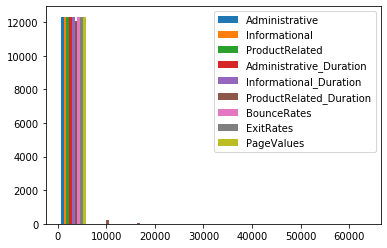

In [3]:
pages = ['Administrative',
         'Informational',
         'ProductRelated',
         'Administrative_Duration',
         'Informational_Duration',
         'ProductRelated_Duration',
         'BounceRates',
         'ExitRates',
         'PageValues']

x_pages = shop.loc[:, pages].values

plt.hist(x_pages, label=pages)
plt.legend()
plt.show()

### Feature scaling

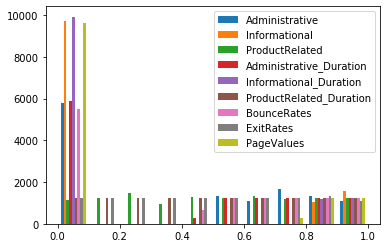

In [4]:
x_pages = QuantileTransformer(output_distribution='uniform').fit_transform(x_pages)
plt.hist(x_pages, label=pages)
plt.legend()
plt.show()

### Dimension reduction

% variance explained: 98.07948987307486


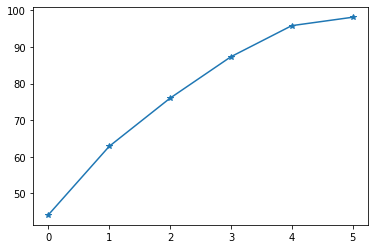

In [5]:
pca = PCA(n_components=6)

pca.fit(x_pages)

print("% variance explained:", sum(pca.explained_variance_ratio_)*100)
variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(variance, marker='*')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


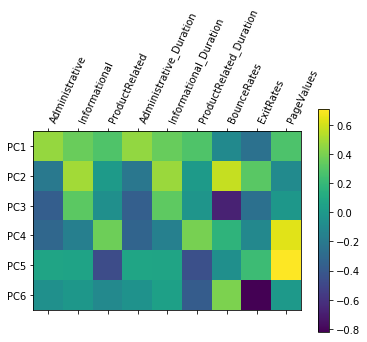

In [62]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0, 1, 2, 3, 4, 5],['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], fontsize=10)
plt.colorbar()
plt.xticks(range(len(pages)),pages,rotation=65,ha='left')
plt.tight_layout()
plt.show()

# Data preparation

In [0]:
pages_pca = pca.fit_transform(x_pages)

df_pages_pca = pd.DataFrame(data = pages_pca,
                            columns = ['pages_pc1',
                                       'pages_pc2',
                                       'pages_pc3',
                                       'pages_pc4',
                                       'pages_pc5',
                                       'pages_pc6'])

shop['is_weekend'] = np.where(shop['Weekend']==True, 1, 0)
shop['returning_visitor'] = np.where(shop['VisitorType']=="Returning_Visitor", 1, 0)

# 0 1 labels for Logistic Regression
shop['purchase'] = np.where(shop['Revenue']==True, 1, 0)

# -1 1 labels for SVM
# shop['purchase'] = np.where(shop['Revenue']==True, 1, -1)

cols = ['is_weekend',
        'returning_visitor',
        'SpecialDay',
        'purchase']
df_shop = shop.loc[:, cols]

# Generate data, fit model, and evaluate

In [0]:
def generate_data(df_pca, df_raw, labels):
  pca_cols, raw_cols = df_pca.columns, df_raw.columns
  
  # Remove labels from features
  raw_cols = raw_cols[ raw_cols != labels ]

  # Prepare combinations of raw features
  raw_combos = []
  for i in range(1, len(raw_cols)+1):
    for combo in itertools.combinations(raw_cols, i):
      raw_combos += [list(combo)]
  
  for pca_idx in range( len(pca_cols), 3, -1):
    for raw_combo in raw_combos:
      pca_combo = pca_cols[:pca_idx]
      
      x = pd.concat( [df_pca.loc[:, pca_combo], df_raw.loc[:, raw_combo]], axis=1 )
      y = df_raw[labels]

      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

      yield x_train, x_test, y_train, y_test

In [0]:
def fit_log_reg(x_train, y_train):
  lr_model = LogisticRegression()

  # solver = ['lbfgs', 'newton-cg']
  # C = np.logspace(0, 4, 10)
  solver = ['lbfgs']
  C = [1]

  hyperparams = dict(solver=solver, C=C)

  # 5-fold cross-validation
  clf = GridSearchCV(lr_model, hyperparams, cv=5, n_jobs=-1)
  model = clf.fit(x_train, y_train)

  return model

def fit_svm(x_train, y_train):
  svm_model = SVC()

  # C = [0.1, 1, 10, 100, 1000]
  C = [1, 10]
  # gamma = [1, 0.1, 0.01, 0.001, 0.0001]
  gamma = ['scale', 'auto']
  # kernel = ['rbf', 'linear', 'poly']
  kernel = ['rbf', 'poly']

  hyperparams = dict(kernel=kernel, C=C, gamma=gamma)

  # 5-fold cross-validation
  clf = GridSearchCV(svm_model, hyperparams, cv=5, verbose=2, n_jobs=-1)
  model = clf.fit(x_train, y_train)

  print(model.best_params_)

  return model

In [0]:
def evaluate(model, x_test, y_test, results):
  predictions = model.predict(x_test)

  C = metrics.confusion_matrix(y_test, predictions)

  n_samples = len(y_test)
  tn, fp, fn, tp = C[0][0], C[0][1], C[1][0], C[1][1]
  
  precision = tp / (tp + fp) * 100
  recall = tp / (tp + fn) * 100
  accuracy = (tp + tn) / (tp + fp + tn + fn) * 100

  print("\n\nResults for model with features:", x_test.columns.values)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)

  # Populate results in dict
  results[tuple(x_test.columns)] = {"accuracy" : accuracy,
                                    "precision" : precision,
                                    "recall" : recall}
  
  return None

## Fit and evaluate logistic regression model

In [0]:
train_results = {}
test_results = {}

for x_train, x_test, y_train, y_test in generate_data(df_pca=df_pages_pca, df_raw=df_shop, labels='purchase'):
  model = fit_log_reg(x_train=x_train, y_train=y_train)
  evaluate(model=model, x_test=x_train, y_test=y_train, results=train_results)
  evaluate(model=model, x_test=x_test, y_test=y_test, results=test_results)



Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend']
Accuracy: 90.02433090024331
Precision: 68.65671641791045
Recall: 60.80870917573873


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend']
Accuracy: 88.83482022168153
Precision: 70.2127659574468
Recall: 58.36012861736335


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor']
Accuracy: 90.14019232997336
Precision: 70.19498607242339
Recall: 58.78693623639192


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor']
Accuracy: 88.48337388483374
Precision: 70.08196721311475
Recall: 54.983922829581985


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'SpecialDay']
Accuracy: 89.85053875564824
Precision: 

## Fit and evaluate Support Vector Machines model

In [0]:
# NB: Remember to modify label into +1 -1 instead of 1 0 for SVM

train_results = {}
test_results = {}

for x_train, x_test, y_train, y_test in generate_data(df_pca=df_pages_pca, df_raw=df_shop, labels='purchase'):
  model = fit_svm(x_train=x_train, y_train=y_train)
  evaluate(model=model, x_test=x_train, y_test=y_train, results=train_results)
  evaluate(model=model, x_test=x_test, y_test=y_test, results=test_results)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   27.6s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend']
Accuracy: 90.8353609083536
Precision: 77.84026996625421
Recall: 53.810264385692065


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend']
Accuracy: 88.37523655041903
Precision: 73.07692307692307
Recall: 48.87459807073955
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.1s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor']
Accuracy: 90.39508747537944
Precision: 78.24474660074165
Recall: 49.22239502332815


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor']
Accuracy: 88.51040821843742
Precision: 75.98944591029023
Recall: 46.30225080385852
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   28.2s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'SpecialDay']
Accuracy: 90.33715676051443
Precision: 76.34032634032634
Recall: 50.93312597200622


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'SpecialDay']
Accuracy: 88.56447688564477
Precision: 75.18987341772151
Recall: 47.7491961414791
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.8s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend' 'returning_visitor']
Accuracy: 90.32557061754142
Precision: 78.58048162230672
Recall: 48.21150855365474


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend' 'returning_visitor']
Accuracy: 88.53744255204109
Precision: 76.32978723404256
Recall: 46.141479099678456
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   26.8s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend' 'SpecialDay']
Accuracy: 90.96280848105665
Precision: 78.04878048780488
Recall: 54.74339035769829


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend' 'SpecialDay']
Accuracy: 88.67261422005947
Precision: 74.34052757793765
Recall: 49.839228295819936
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   24.3s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor' 'SpecialDay']
Accuracy: 90.5457073340285
Precision: 76.82648401826484
Recall: 52.332814930015545


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor' 'SpecialDay']
Accuracy: 88.42930521762639
Precision: 74.25
Recall: 47.7491961414791
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   24.5s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend' 'returning_visitor' 'SpecialDay']
Accuracy: 90.73108562159658
Precision: 78.65566037735849
Recall: 51.86625194401244


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend' 'returning_visitor' 'SpecialDay']
Accuracy: 88.78075155447418
Precision: 76.47058823529412
Recall: 48.07073954983923
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   26.9s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'is_weekend']
Accuracy: 90.55729347700151
Precision: 75.96471885336274
Recall: 53.576982892690516


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'is_weekend']
Accuracy: 88.42930521762639
Precision: 73.09523809523809
Recall: 49.356913183279744
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.7s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5'
 'returning_visitor']
Accuracy: 90.30239833159541
Precision: 76.25730994152048
Recall: 50.69984447900466


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5'
 'returning_visitor']
Accuracy: 88.10489321438226
Precision: 72.52475247524752
Recall: 47.10610932475884
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   27.4s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'SpecialDay']
Accuracy: 90.49936276213649
Precision: 75.10775862068965
Recall: 54.19906687402799


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'SpecialDay']
Accuracy: 88.13192754798594
Precision: 71.42857142857143
Recall: 49.035369774919616
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   26.4s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'is_weekend'
 'returning_visitor']
Accuracy: 90.18653690186537
Precision: 77.47183979974969
Recall: 48.13374805598756


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'is_weekend'
 'returning_visitor']
Accuracy: 88.34820221681535
Precision: 76.16438356164383
Recall: 44.69453376205787
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   27.6s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'is_weekend'
 'SpecialDay']
Accuracy: 90.71949947862356
Precision: 76.67766776677668
Recall: 54.19906687402799


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'is_weekend'
 'SpecialDay']
Accuracy: 88.64557988645579
Precision: 73.82075471698113
Recall: 50.32154340836013
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   24.6s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5'
 'returning_visitor' 'SpecialDay']
Accuracy: 90.33715676051443
Precision: 75.79908675799086
Recall: 51.632970451010884


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5'
 'returning_visitor' 'SpecialDay']
Accuracy: 88.24006488240065
Precision: 73.43358395989975
Recall: 47.10610932475884
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.5s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'is_weekend'
 'returning_visitor' 'SpecialDay']
Accuracy: 90.27922604564941
Precision: 77.83312577833127
Recall: 48.600311041990665


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'is_weekend'
 'returning_visitor' 'SpecialDay']
Accuracy: 88.4022708840227
Precision: 76.43835616438356
Recall: 44.855305466237944
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.9s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'is_weekend']
Accuracy: 89.78102189781022
Precision: 75.63451776649747
Recall: 46.3452566096423


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'is_weekend']
Accuracy: 87.86158421194918
Precision: 74.09470752089136
Recall: 42.765273311897104
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.2s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'returning_visitor']
Accuracy: 89.68833275402619
Precision: 76.4
Recall: 44.556765163297044


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'returning_visitor']
Accuracy: 87.72641254393079
Precision: 74.27745664739885
Recall: 41.31832797427653
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   22.7s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'SpecialDay']
Accuracy: 89.83895261267524
Precision: 76.1843790012804
Recall: 46.26749611197511


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'SpecialDay']
Accuracy: 87.99675587996757
Precision: 74.31693989071039
Recall: 43.729903536977496
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.6s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'is_weekend'
 'returning_visitor']
Accuracy: 89.76943575483722
Precision: 77.56497948016415
Recall: 44.09020217729393


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'is_weekend'
 'returning_visitor']
Accuracy: 87.80751554474182
Precision: 75.37091988130564
Recall: 40.836012861736336
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   22.1s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'is_weekend' 'SpecialDay']
Accuracy: 89.83895261267524
Precision: 75.78814627994956
Recall: 46.734059097978225


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'is_weekend' 'SpecialDay']
Accuracy: 87.96972154636387
Precision: 74.3801652892562
Recall: 43.40836012861736
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.2s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'returning_visitor'
 'SpecialDay']
Accuracy: 89.76943575483722
Precision: 76.47831800262811
Recall: 45.25660964230171


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'returning_visitor'
 'SpecialDay']
Accuracy: 87.72641254393079
Precision: 74.13793103448276
Recall: 41.47909967845659
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.9s finished


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'is_weekend'
 'returning_visitor' 'SpecialDay']
Accuracy: 89.80419418375622
Precision: 77.06666666666668
Recall: 44.94556765163297


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'is_weekend'
 'returning_visitor' 'SpecialDay']
Accuracy: 87.78048121113815
Precision: 75.0
Recall: 40.9967845659164


# Identify best candidate model

In [0]:
for features, met in train_results.items():
  # print(features)
  # print(met['accuracy'])
  # print(met['precision'])
  print(met['recall'])

53.810264385692065
49.22239502332815
50.93312597200622
48.21150855365474
54.74339035769829
52.332814930015545
51.86625194401244
53.576982892690516
50.69984447900466
54.19906687402799
48.13374805598756
54.19906687402799
51.632970451010884
48.600311041990665
46.3452566096423
44.556765163297044
46.26749611197511
44.09020217729393
46.734059097978225
45.25660964230171
44.94556765163297


In [0]:
for features, met in test_results.items():
  # print(features)
  # print(met['accuracy'])
  # print(met['precision'])
  print(met['recall'])

48.87459807073955
46.30225080385852
47.7491961414791
46.141479099678456
49.839228295819936
47.7491961414791
48.07073954983923
49.356913183279744
47.10610932475884
49.035369774919616
44.69453376205787
50.32154340836013
47.10610932475884
44.855305466237944
42.765273311897104
41.31832797427653
43.729903536977496
40.836012861736336
43.40836012861736
41.47909967845659
40.9967845659164


# Fit best candidate model

In [59]:
# x = pd.concat( [df_pages_pca, df_shop.loc[:, ['is_weekend', 'SpecialDay']]], axis=1 )
x = df_pages_pca
y = df_shop['purchase']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

lr_model = LogisticRegression(C=1, solver='lbfgs')
best_model = lr_model.fit(x_train, y_train)

train_results = {}
evaluate(model=best_model, x_test=x_train, y_test=y_train, results=train_results)
test_results = {}
evaluate(model=best_model, x_test=x_test, y_test=y_test, results=test_results)



Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6']
Accuracy: 89.96640018537829
Precision: 68.19757365684576
Recall: 61.19751166407465


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6']
Accuracy: 88.75371722087051
Precision: 69.8076923076923
Recall: 58.36012861736335


In [58]:
print(best_model.classes_)
print(best_model.coef_)

[0 1]


AttributeError: ignored

In [0]:
def odds_and_probs(train, label, binaryVar):
  df = train[train[label] == 1].groupby(train[binaryVar]).count()[[label]]
  df['Total'] = train[label].groupby(train[binaryVar]).count()
  df['not_' + label] = df.Total - df[label]
  df['OddsOF' + label] = df[label] / df['not_' + label]
  df['ProbOF' + label] = df[label] / df.Total
  df['Log(OddsOF' + label + ')'] = np.log(df['OddsOF' + label])

  return df

In [36]:
df_weekend = odds_and_probs(train=df_shop, label='purchase', binaryVar='is_weekend')
df_weekend

,purchase,Total,not_purchase,OddsOFpurchase,ProbOFpurchase,Log(OddsOFpurchase)
is_weekend,,,,,,
0,1409,9462,8053,0.174966,0.148911,-1.743164
1,499,2868,2369,0.210637,0.173989,-1.557617


In [37]:
df_SpecialDay = odds_and_probs(train=df_shop, label='purchase', binaryVar='SpecialDay')
df_SpecialDay

,purchase,Total,not_purchase,OddsOFpurchase,ProbOFpurchase,Log(OddsOFpurchase)
SpecialDay,,,,,,
0.0,1831,11079,9248,0.197989,0.165268,-1.619545
0.2,14,178,164,0.085366,0.078652,-2.460809
0.4,13,243,230,0.056522,0.053498,-2.873130
0.6,29,351,322,0.090062,0.082621,-2.407256
0.8,11,325,314,0.035032,0.033846,-3.351498
1.0,10,154,144,0.069444,0.064935,-2.667228


# Plot ROC curve

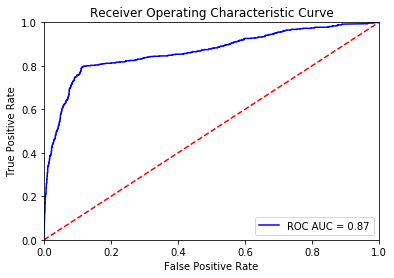

In [60]:
probs = best_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'ROC AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

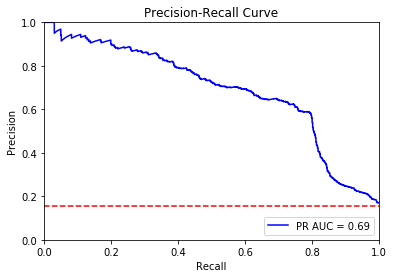

In [61]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, preds)

pr_auc = metrics.auc(recall, precision)

plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'b', label = 'PR AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.155, 0.155],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()